In [29]:
import os
import json
import pandas as pd

# Diretórios com os arquivos (ajuste conforme necessário)
respostas_dir = "dados/output_llms/"       # onde ficam os jsons com o código gerado
avaliacoes_dir = "dados/output/"   # onde ficam os jsons com a avaliação

# Função para ler todos os arquivos JSON de um diretório
def carregar_jsons(diretorio):
    arquivos = [os.path.join(diretorio, f) for f in os.listdir(diretorio) if f.endswith('.json')]
    jsons = []
    for arquivo in arquivos:
        with open(arquivo, 'r', encoding='utf-8') as f:
            try:
                dados = json.load(f)
                jsons.append(dados)
            except json.JSONDecodeError:
                print(f"Erro ao carregar: {arquivo}")
    return jsons

# Carrega todos os arquivos de respostas e avaliações
respostas_jsons = carregar_jsons("dados/output_llms/")
avaliacoes_jsons = carregar_jsons("dados/output/")

# Lista onde iremos armazenar os dados combinados
dados_combinados = []

# Para cada par de arquivos (resposta + avaliação)
for idx, (respostas, avaliacoes) in enumerate(zip(respostas_jsons, avaliacoes_jsons)):
    has_docstring = idx < 15  # True para os 15 primeiros
    for llm, tipos in respostas.items():
        for tipo_prompt, codigo_gerado in tipos.items():
            aval = avaliacoes.get(llm, {}).get(tipo_prompt, {})
            dados_combinados.append({
                "llm": llm,
                "prompt_type": tipo_prompt,
                "has_docstring": has_docstring,
                "code": codigo_gerado,
                "status": aval.get("status"),
                "score": aval.get("score"),
                "coverage": aval.get("coverage", "-"),
                "assert_types": ', '.join(aval.get("assert_types", [])),
                "edge_case_found": aval.get("edge_case_found", False),
                "functions_tested": aval.get("functions_tested", 0),
                "total_functions": aval.get("total_functions", 0),
                "test_smells": json.dumps(aval.get("test_smells", {}), ensure_ascii=False),
                "stderr": aval.get("stderr", ""),
                "stdout": aval.get("stdout", "")
            })

# Criação do DataFrame
df = pd.DataFrame(dados_combinados)
df.to_json("df_completo.json", orient="records", lines=False)

code_models = {"CodeGemma", "CodeLLaMA", "WizardCoder"}
df["llm_type"] = df["llm"].apply(lambda x: "Focado em Código" if x in code_models else "Geral")

df

,llm,prompt_type,has_docstring,code,status,score,coverage,assert_types,edge_case_found,functions_tested,total_functions,test_smells,stderr,stdout,llm_type
0,WizardCoder,zero-shot,True,Here are some examples of unit tests to test t...,failed,0.62,-,"assertEqual, assertRaises",True,1,1,"{""magic_number"": 37}","Traceback (most recent call last):\n File ""C:...",,Focado em Código
1,WizardCoder,few-shot,True,Here are the unit tests for `intersperse` func...,failed,0.62,-,"assertEqual, assertRaises",True,1,1,"{""syntax_error"": 1}",C:\Users\antho\OneDrive\Área de Trabalho\testP...,Couldn't run 'C:\Users\antho\OneDrive\Área de ...,Focado em Código
2,WizardCoder,cot,True,"Here are the unit tests that cover edge cases,...",passed,2.67,9%,"assertEqual, assertRaises",True,1,1,"{""assertion_roulette"": 3, ""magic_number"": 24}",,,Focado em Código
3,CodeLLaMA,zero-shot,True,Here are some unit tests for the `intersperse`...,failed,0.55,-,assertEqual,True,1,1,"{""magic_number"": 31}",FF....\n======================================...,,Focado em Código
4,CodeLLaMA,few-shot,True,def test_intersperse_empty_list():\n assert...,no_code_found,0.00,-,,False,0,0,{},,,Focado em Código
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,Gemma,few-shot,False,```python\nimport unittest\n\nclass TestTrunca...,failed,0.22,-,"assertEqual, assertRaises",True,1,1,"{""redundant_assertion"": 2, ""magic_number"": 3, ...",.FFF.\n=======================================...,,Geral
518,Gemma,cot,False,**Step-by-step analysis:**\n\n**Edge cases:**\...,failed,0.22,-,"assertEqual, assertRaises",True,1,1,"{""magic_number"": 5, ""redundant_assertion"": 1, ...",FF...\n=======================================...,,Geral
519,CodeGemma,zero-shot,False,```python\nimport unittest\n\nclass TestTrunca...,failed,0.35,-,assertEqual,True,1,1,"{""redundant_assertion"": 2, ""magic_number"": 7}",.FF..\n=======================================...,,Focado em Código
520,CodeGemma,few-shot,False,```python\nimport unittest\n\nclass TestTrunca...,no_code_found,0.00,-,,False,0,0,{},,,Focado em Código


# RQ1

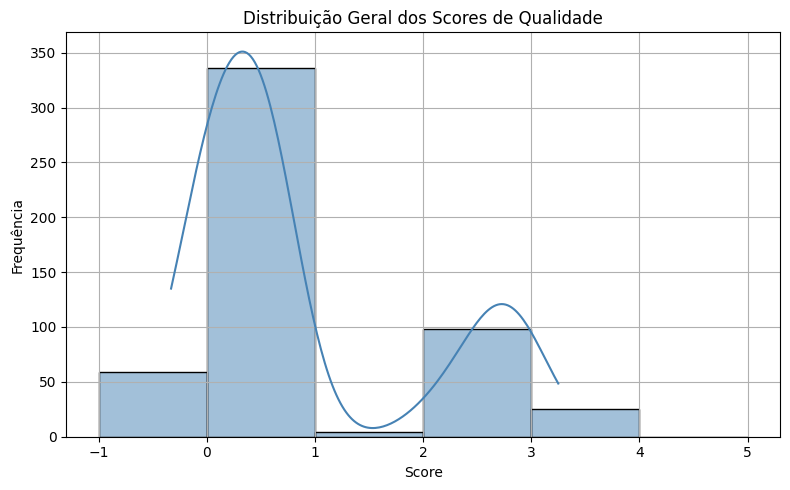

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np  # ← aqui está a correção

plt.figure(figsize=(8, 5))
sns.histplot(df["score"], bins=np.arange(-1, 5.5, 1), kde=True, color="steelblue")

plt.title("Distribuição Geral dos Scores de Qualidade")
plt.xlabel("Score")
plt.ylabel("Frequência")
plt.grid(True)
plt.tight_layout()
plt.show()


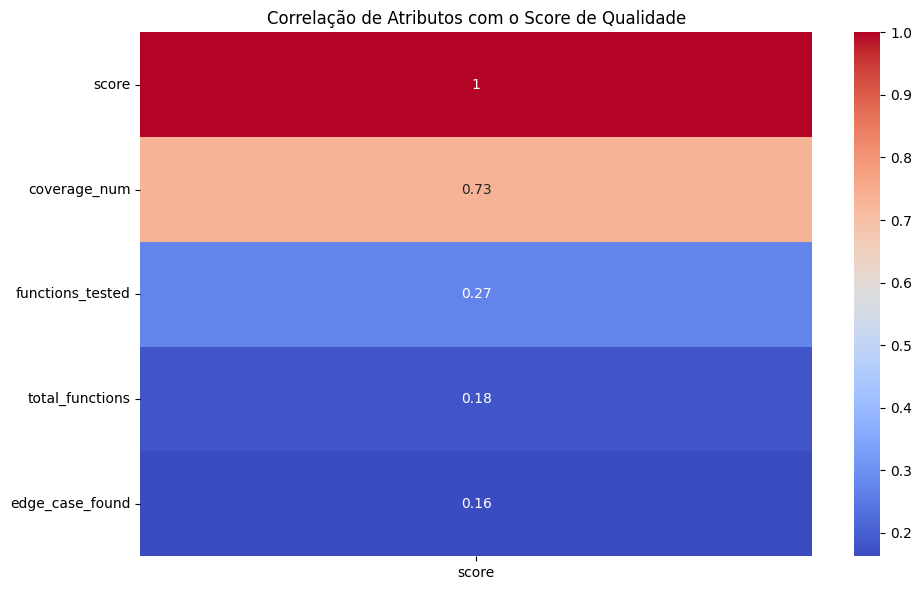

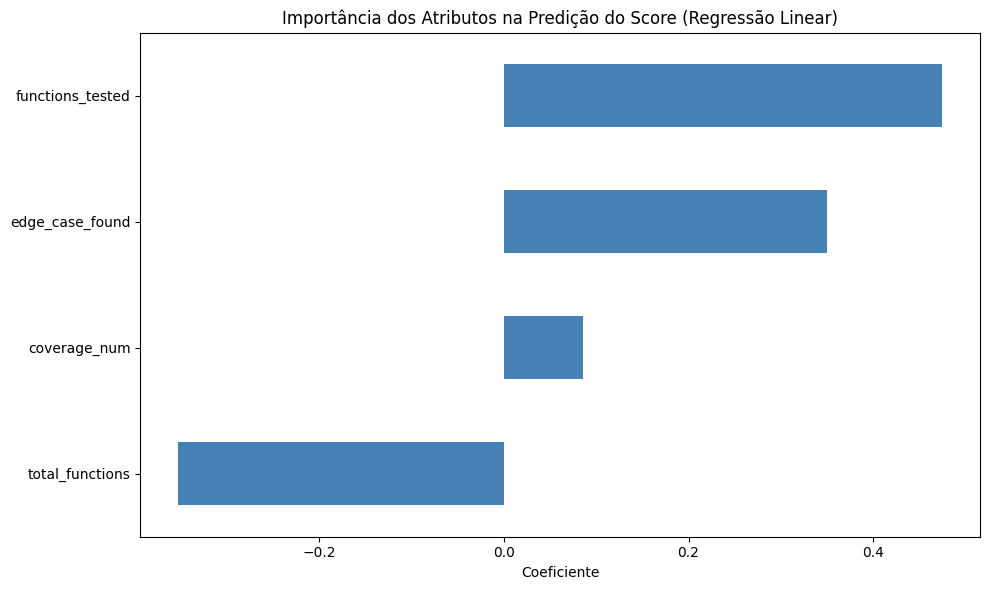

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# --- Carrega o DataFrame ---
df = pd.read_json("df_completo.json").copy()

# --- Expandindo test_smells corretamente ---
df['test_smells'] = df['test_smells'].apply(lambda x: x if isinstance(x, dict) else {})

# Transforma os dicionários de smells em colunas
smells_df = df['test_smells'].apply(pd.Series).fillna(0).astype(int)
smells_df.columns = [f"smell_{col}" for col in smells_df.columns]

# --- Convertendo cobertura e atributos numéricos ---
df["coverage_num"] = df["coverage"].str.replace('%', '', regex=False)
df["coverage_num"] = pd.to_numeric(df["coverage_num"], errors="coerce").fillna(0)
df["edge_case_found"] = df["edge_case_found"].astype(int)

# --- Concatenando tudo ---
df_combined = pd.concat([
    df[["score", "coverage_num", "functions_tested", "total_functions", "edge_case_found"]],
    smells_df
], axis=1)

# --- Correlação com o score ---
corr = df_combined.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr[["score"]].sort_values(by="score", ascending=False), annot=True, cmap="coolwarm")
plt.title("Correlação de Atributos com o Score de Qualidade")
plt.tight_layout()
plt.show()

# --- Regressão Linear para importância dos atributos ---
X = df_combined.drop(columns=["score"])
y = df_combined["score"]

model = LinearRegression()
model.fit(X, y)

coef = pd.Series(model.coef_, index=X.columns).sort_values()

plt.figure(figsize=(10, 6))
coef.plot(kind="barh", color="steelblue")
plt.title("Importância dos Atributos na Predição do Score (Regressão Linear)")
plt.xlabel("Coeficiente")
plt.tight_layout()
plt.show()


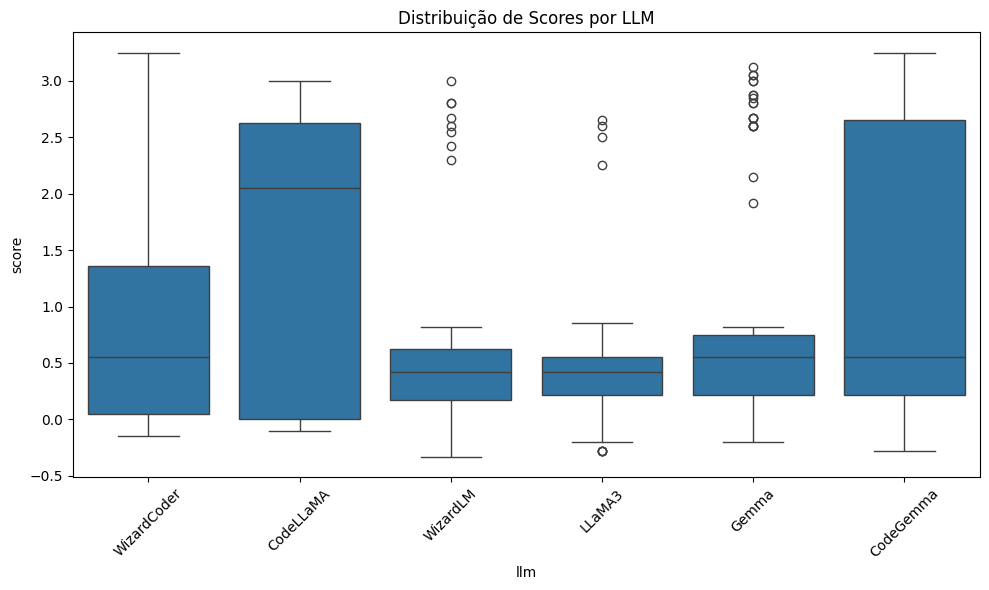

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="llm", y="score")
plt.title("Distribuição de Scores por LLM")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


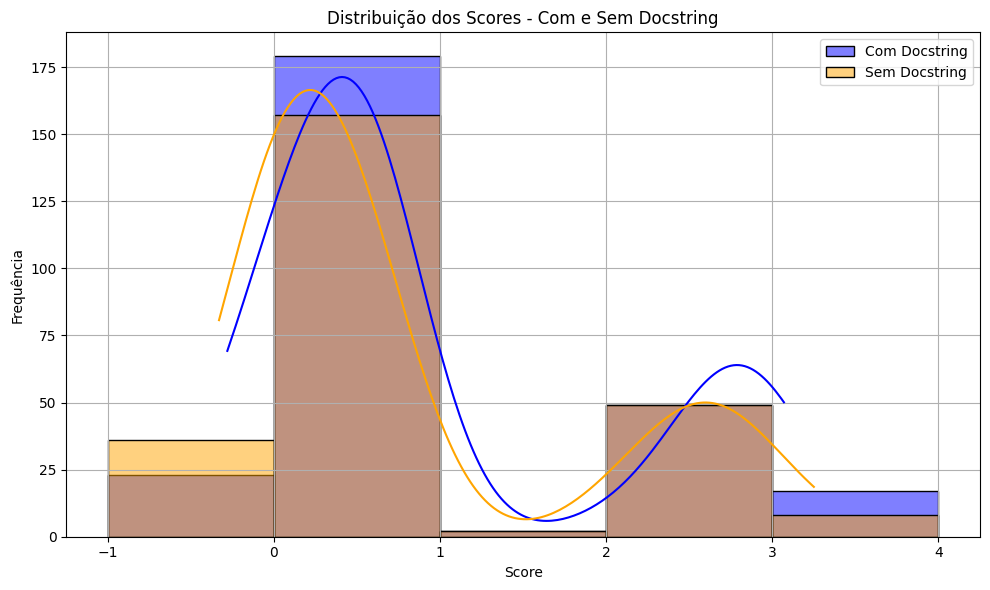

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

# Define bins de -1 até 4 com passo 1
bins = list(range(-1, 5))  # -1, 0, 1, 2, 3, 4

# Histograma separado por presença de docstring
sns.histplot(data=df[df["has_docstring"] == 1], x="score", bins=bins, color="blue", label="Com Docstring", kde=True)
sns.histplot(data=df[df["has_docstring"] == 0], x="score", bins=bins, color="orange", label="Sem Docstring", kde=True)

plt.title("Distribuição dos Scores - Com e Sem Docstring")
plt.xlabel("Score")
plt.ylabel("Frequência")
plt.xticks(bins)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\antho\AppData\Local\Temp\ipykernel_8852\2827453987.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="llm_type", y="score", palette="Set2")


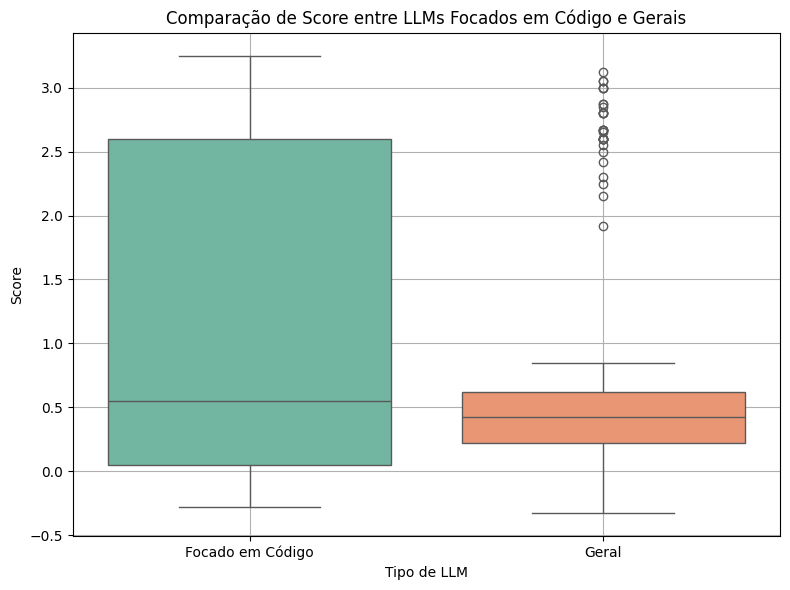

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x="llm_type", y="score", palette="Set2")

plt.title("Comparação de Score entre LLMs Focados em Código e Gerais")
plt.xlabel("Tipo de LLM")
plt.ylabel("Score")
plt.grid(True)
plt.tight_layout()
plt.show()


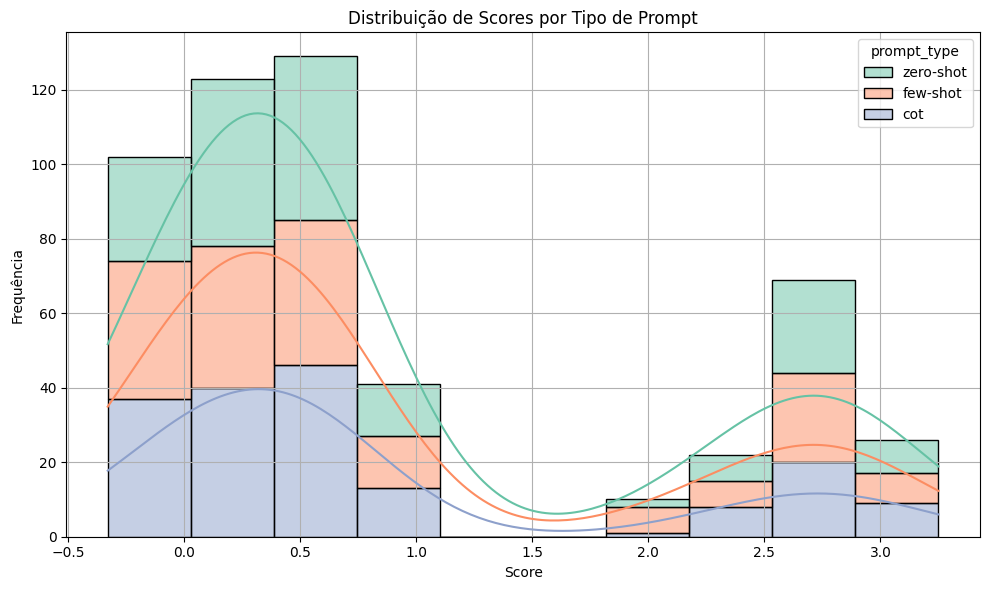

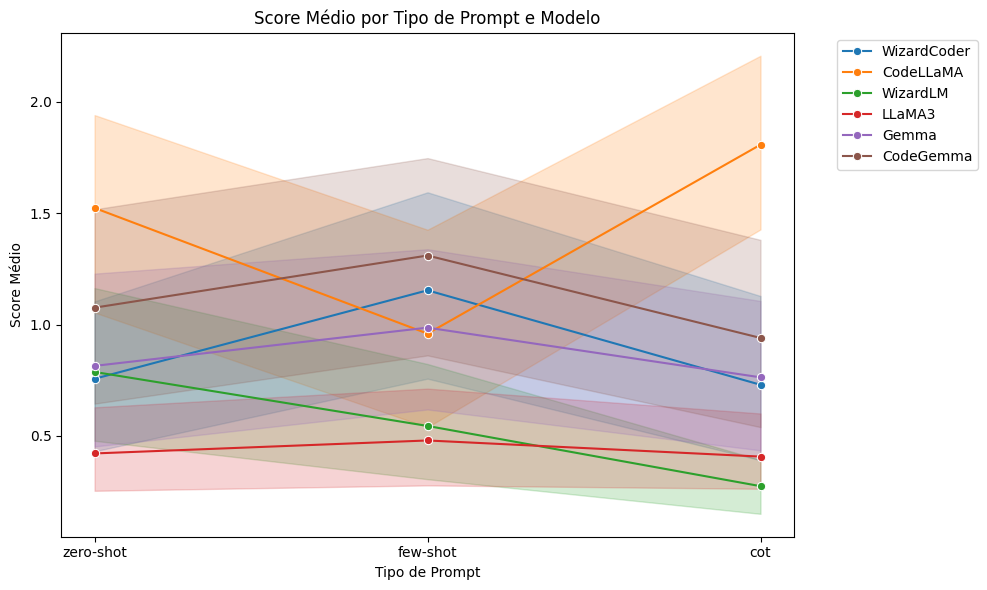

In [21]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="score", hue="prompt_type", kde=True, bins=10, palette="Set2", multiple="stack")

plt.title("Distribuição de Scores por Tipo de Prompt")
plt.xlabel("Score")
plt.ylabel("Frequência")
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="prompt_type", y="score", hue="llm", marker="o")

plt.title("Score Médio por Tipo de Prompt e Modelo")
plt.xlabel("Tipo de Prompt")
plt.ylabel("Score Médio")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
